# Classification of b-quark jets in the Aleph simulated data

Python macro for selecting b-jets (sprays of particles with a b-quark in it) in Aleph Z -> qqbar MC (i.e. simulated decays of the Z0 boson decaying to a quark and an anti-quark) in various ways:
* Initially, simply with "if"-statements making requirements on certain variables. This corresponds to selecting "boxes" in the input variable space (typically called "X"). One could also try a Fisher discriminant (linear combination of input variables), which corresponds to a plane in the X-space. But as the problem is non-linear, it is likely to be sub-optimal.

* Next using Machine Learning (ML) methods. We will during the first week try both (Boosted) Decision Tree ((B)DT) based and Neural Net (NN) based methods, and see how complicated (or not) it is to get a good solution, and how much better it performs compared to the "classic" selection method.

Once you obtain a classification of b-jets vs. non-b-jets, think about how to quantify the quality of your algorithm. Also, try to compare it to the NN result of the Aleph collaboration, given by the variable "nnbjet". It is based on a neural network with 6 input variables (prob_b, spheri, pt2rel, multip, bqvjet, and ptlrel), and two hidden layers each with 10 nodes in. Can you do better?

In the end, this exercise is the simple start on moving into the territory of Machine Learning analysis.


### Data:
The input variables (X) are (where Aleph uses only the latter six):
* energy: Measured energy of the jet in GeV. Should be 45 GeV, but fluctuates.
* cTheta: cos(theta), i.e. the polar angle of the jet with respect to the beam axis. Note, that the detector works best in the central region (|cTheta| small) and less well in the forward regions.
* phi:    The azimuth angle of the jet. As the detector is uniform in phi, this should not matter (much).
* prob_b: Probability of being a b-jet from the pointing of the tracks to the vertex.
* spheri: Sphericity of the event, i.e. how spherical it is.
* pt2rel: The transverse momentum squared of the tracks relative to the jet axis, i.e. width of the jet.
* multip: Multiplicity of the jet (in a relative measure).
* bqvjet: b-quark vertex of the jet, i.e. the probability of a detached vertex.
* ptlrel: Transverse momentum (in GeV) of possible lepton with respect to jet axis (about 0 if no leptons).

The target variable (Y) is:
* isb:    1 if it is from a b-quark and 0, if it is not.

Finally, those before you (the Aleph collaboration in the mid 90'ies) produced a Neural Net (6 input variables, two hidden layers with 10 neurons in each, and 1 output varible) based classification variable, which you can compare to (and compete with?):
* nnbjet: Value of original Aleph b-jet tagging algorithm, using only the last six variables (for reference).


### Task:
Thus, the task before you is to produce functions (non-ML and then ML algorithm), which given the input variables X provides an output variable estimate, Y_est, which is "closest possible" to the target variable, Y. The "closest possible" is left to the user to define in a _Loss Function_, which we will discuss further. In classification problems (such as this), the typical loss function to use "Cross Entropy", see https://en.wikipedia.org/wiki/Cross_entropy.

Once you have results, you're welcome to continue with a Fisher Linear Discriminant, and you may also challenge yourself by considering "v1" of the data, which is a little less "polished and ready". If you also manage this, then don't hold back in applying a real ML algorithm to the problem (you can get inspiration from "ML_MethodsDemos.ipynb" or the vast internet). A suggestion might be XGBoost or LightGBM.

* Author: Troels C. Petersen and Rasmus Ørsøe (NBI)
* Email:  petersen@nbi.dk, pcs557@alumni.ku.dk
* Date:   17th of April 2022

In [1]:
from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import numpy as np
import csv

import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

Possible other packages to consider:
cornerplot, seaplot, sklearn.decomposition(PCA)

In [2]:
r = np.random
r.seed(42)

SavePlots = False
plt.close('all')

# Evaluate an attempt at classification:

This is made into a function, as this is called many times. It returns a "confusion matrix" and the fraction of wrong classifications.

In [3]:
def evaluate(bquark) :
    N = [[0,0], [0,0]]   # Make a list of lists (i.e. confusion matrix) for counting successes/failures.
    for i in np.arange(len(isb)):
        if (bquark[i] == 0 and isb[i] == 0) : N[0][0] += 1
        if (bquark[i] == 0 and isb[i] == 1) : N[0][1] += 1
        if (bquark[i] == 1 and isb[i] == 0) : N[1][0] += 1
        if (bquark[i] == 1 and isb[i] == 1) : N[1][1] += 1
    fracWrong = float(N[0][1]+N[1][0])/float(len(isb))
    accuracy = 1.0 - fracWrong
    return N, accuracy, fracWrong

# Classify B-jets using TensorFlow:

This is a solution example using TensorFlow (NN based).

The example is built with inspiration from
https://blog.cmgresearch.com/2020/09/06/tensorflow-binary-classification.html

The link contains additional explanitory text and short 5-minute youtube video explaining core concepts.

__Note:
The solution NNs below (both in TensorFlow and PyTorch) are very simple and un-optimized models. Yet they manage to  achieves a slightly bit higher AUC score than nnbjet (higher is better). But they can be further optimised, which we will be working on more, in particular for the initial/individual project.__

# Read the data

...and choose input and target variables:

A few worlds on the variables and feature choices:
* 'isb' is our binary truth variables. If isb = 1 then it's a b-quark and isb = 0 if it is not.
   Because this is our truth, we must not include it as the input to our model.
* 'nnbjet' is our "competitor" e.g. a model we are supposed to benchmark against.
   Therefore 'nnbjet' shouldn't be in our input either.
* 'energy', 'cTheta', and 'phi' are kinematic variables of the jet, and not about the jet type.
   Though they might help, they were not in the original Aleph NN (nnbjet), and to compare, we omit them.

Usually one would apply further checks/regularization/standardization of data at this step, but this data has already been "prepared", so we'll move onto seperate the data into input, truth and benchmark:

In [4]:
# Load 2nd version of the Aleph Data.
path = 'AlephBtag_MC_small_v2.csv'
data = pd.DataFrame(np.genfromtxt(path, names=True))
variables = data.columns
print(variables)

input_variables = variables[(variables != 'nnbjet') & (variables != 'isb') & (variables != 'energy') & (variables != 'cTheta') & (variables != 'phi')]
input_data      = data[input_variables]
truth_data      = data['isb']
benchmark_data  = data['nnbjet']
print(input_variables)

Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel', 'nnbjet', 'isb'],
      dtype='object')
Index(['prob_b', 'spheri', 'pt2rel', 'multip', 'bqvjet', 'ptlrel'], dtype='object')


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

input_train, input_valid, truth_train, truth_valid = train_test_split(input_data, truth_data, test_size=0.25, random_state=42)

model = Sequential([
    Dense(9,activation='relu',name='input_layer'),
    Dense(24,activation='relu',name='hidden_layer1'),
    Dense(12,activation='relu',name='hidden_layer2'),
    Dense(1, activation='sigmoid', name='output')])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.losses.BinaryCrossentropy()])

print('--------- TRAINING ---------')
history = model.fit(x = np.array(input_train), y = np.array(truth_train), validation_data=(np.array(input_valid), np.array(truth_valid)), epochs = 5)  
## This trains the model on input_train by comparing to the true values in truth_train. After every epoch of training, the model is evaluated on the validation dataset, 
## namely input_valid and truth_valid.

--------- TRAINING ---------
Train on 25476 samples, validate on 8492 samples
Epoch 1/5
25476/25476 [==============================] - 2s 88us/sample - loss: 0.3211 - binary_crossentropy: 0.3216 - val_loss: 0.2643 - val_binary_crossentropy: 0.2646
Epoch 2/5
25476/25476 [==============================] - 1s 51us/sample - loss: 0.2671 - binary_crossentropy: 0.2670 - val_loss: 0.2632 - val_binary_crossentropy: 0.2635
Epoch 3/5
25476/25476 [==============================] - 1s 51us/sample - loss: 0.2667 - binary_crossentropy: 0.2668 - val_loss: 0.2659 - val_binary_crossentropy: 0.2661
Epoch 4/5
25476/25476 [==============================] - 1s 50us/sample - loss: 0.2663 - binary_crossentropy: 0.2668 - val_loss: 0.2653 - val_binary_crossentropy: 0.2655
Epoch 5/5
25476/25476 [==============================] - 1s 51us/sample - loss: 0.2659 - binary_crossentropy: 0.2666 - val_loss: 0.2620 - val_binary_crossentropy: 0.2623


(array([0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33]),
 <a list of 9 Text yticklabel objects>)

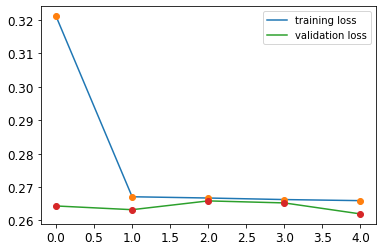

In [6]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

fig =  plt.figure()
plt.plot(training_loss,label = 'training loss')
plt.plot(training_loss,'o')
plt.plot(validation_loss, label = 'validation loss')
plt.plot(validation_loss, 'o')
plt.legend()
plt.xticks(size = 12)
plt.yticks(size = 12)

#### Discussion:
As you can see, after 1st epoch the validation loss and training loss match/cross each other. This is important! Do you know why?

Now we have a trained model and we're ready to make predictions. Usually, one would have a test set (so in total one would have; a training set, a validation set AND a test set). But for simplicity, let's just predict on the validation sample. This is OK because the model has not trained on this set - if we asked the model to predict on examples on which it has trained, we would be cheating!

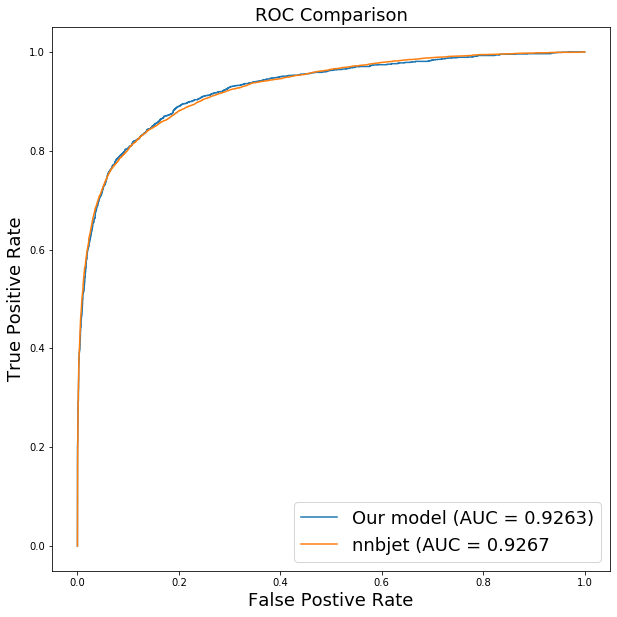

In [7]:
# Make predictions on input_valid and plot performance (ROC curve). Notice we're not giving it any truth values!
predictions = model.predict(input_valid)

fpr, tpr, _ = roc_curve(truth_valid, predictions)      # False Positive Rate and True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth_data, benchmark_data) # False Positive Rate and True Positive Rate for ALEPH model

# We can now calculate the AUC scores of these ROC-curves:
auc_score = auc(fpr,tpr)                         # this is auc score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)   # this is the auc score for nnbjet

# Plot the results:
fig = plt.figure(figsize = [10,10])
plt.title('ROC Comparison', size = 18)
plt.xlabel('False Postive Rate', size = 18)
plt.ylabel('True Positive Rate', size = 18)
plt.plot(fpr,        tpr,        label = f'Our model (AUC = {auc_score:6.4f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = f'nnbjet (AUC = {auc_score_nnbjet:6.4f}')
plt.legend(loc='lower right', fontsize=18)


# Classify B-jets using PyTorch:

This is a solution example using PyTorch (NN based).

The example is built with inspiration from
https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89

The link contains additional explanitory text and short 5-minute youtube video explaining core concepts.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from scipy.special import expit

#### PyTorch "specials":
PyTorch requires that we put this data into the pytorch-Dataset class, such that we can extract it during training.

PyTorch generally wants things to be written into functions and classes, which makes it slightly less easy to "just use", but once you get acquainted with this, PyTorch is a powerful and versatile tool.

In [9]:
# Training data:
class MyDataset(Dataset):    
    def __init__(self, X_data, y_data):
        self.input = X_data
        self.truth = y_data
        
    def __getitem__(self, index):
        return self.input[index], self.truth[index]
        
    def __len__ (self):
        return len(self.input)

train_data = MyDataset(torch.FloatTensor(np.array(input_train)), 
                       torch.FloatTensor(np.array(truth_train)))
valid_data = MyDataset(torch.FloatTensor(np.array(input_valid)), 
                       torch.FloatTensor(np.array(truth_valid)))

# We can now access input_train via train_data.input and truth_train via train_data.truth,
# and similarly for input_valid and truth_valid:
print(train_data.input)
print(train_data.truth)

tensor([[ 8.7520e-01,  5.9370e-01,  2.6400e-02,  5.5970e-01,  7.5530e-01,
         -3.0000e-04],
        [ 4.9100e-02,  2.0840e-01,  3.4500e-02,  2.2580e-01,  2.0600e-02,
         -3.0000e-04],
        [ 8.0800e-02,  5.0620e-01,  2.3800e-02,  2.5530e-01,  4.5800e-02,
         -3.0000e-04],
        ...,
        [ 1.0400e-02,  2.8100e-01,  7.4400e-02,  3.5270e-01,  5.6000e-03,
         -3.0000e-04],
        [ 8.4020e-01,  7.0940e-01,  5.6500e-02,  2.6690e-01,  4.5620e-01,
          3.7260e-01],
        [ 1.6100e-02,  3.5030e-01,  8.7800e-02,  2.5850e-01,  1.5900e-02,
         -3.0000e-04]])
tensor([1., 0., 0.,  ..., 0., 1., 0.])


In [10]:
# Define the model:
class OurModel(nn.Module):
    def __init__(self):
        super(OurModel, self).__init__()        # Here we define the layers.
        self.input_layer = nn.Linear(6, 24) 
        self.hidden_layer1 = nn.Linear(24, 24)
        self.hidden_layer2 = nn.Linear(24, 12)
        self.output_layer = nn.Linear(12, 2) 
        self.relu = nn.ReLU()
        
    def forward(self, inputs):                  # Here we define how data passes through the layers. 
        x = self.input_layer(inputs)
        x = self.relu(x)
        x = self.hidden_layer1(x)
        x = self.relu(x)
        x = self.hidden_layer2(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

In [11]:
# Training loop:
def Train(model, optimizer, loss_function, train_loader, validation_loader, device, epochs):
    validation_loss = []
    training_loss   = []
    model.train()
    for e in range(0, epochs):
        epoch_loss = 0
        n_minibatches = 0
        for input_train_batch, truth_train_batch in train_loader:
            input_train_batch, truth_train_batch = input_train_batch.to(device), truth_train_batch.to(device)
            optimizer.zero_grad()
            prediction = model(input_train_batch)  # This asks our model to produce predictions on the training batch            
            loss = loss_function(prediction, truth_train_batch.long())  # This calculates the loss
            loss.backward()                                             # This initiates the backpropagation
            optimizer.step()
            epoch_loss += loss.item()
            n_minibatches += 1
        
        # Now that the model have trained 1 epoch, we evaluate the model on the validation set:
        valid_loss = Validate(model, validation_loader, device, loss_function)
        validation_loss.append(valid_loss)
        training_loss.append(epoch_loss/n_minibatches)
        print('EPOCH: %s | training loss: %s  | validation loss: %s'%(e+1,round(epoch_loss/n_minibatches,3), round(valid_loss, 3)))
    return training_loss, validation_loss


def Validate(model, validation_loader, device, loss_function):
    model.eval()
    n_batches  = 0
    validation_loss = 0
    with torch.no_grad():
        for input_valid_batch, truth_valid_batch in validation_loader:
            input_valid_batch, truth_valid_batch = input_valid_batch.to(device), truth_valid_batch.to(device)
            prediction = model(input_valid_batch)
            loss = loss_function(prediction, truth_valid_batch.long())
            validation_loss += loss.item()
            n_batches += 1
    validation_loss = validation_loss/n_batches
    return validation_loss


def Predict(model, prediction_loader, device):
    model.eval()
    predictions = []
    print('PREDICTING!')
    with torch.no_grad():
        for input_pred_batch, _ in validation_loader:
            input_pred_batch = input_pred_batch.to(device)
            prediction = model(input_pred_batch)
            predictions.extend(prediction.numpy())
    print('Done Predicting!')
    return predictions

In [12]:
# Now everything is ready, and we thus define the optimisation (hyper-) parameters:
learning_rate = 1e-3      # The step size in the direction of "good" from stocastic gradient descent (important!)
batch_size    = 32        # The size of the batches used for each of the stocastic gradient descent calculations
n_epochs      = 10        # Number of epochs, i.e. times that we run through the entire dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OurModel() 
model.to(device)       # Mount the model to the selected device. Either CPU or GPU.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = CrossEntropyLoss()
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=valid_data, batch_size=batch_size)

training_loss, validation_loss = Train(model, optimizer, loss_function, train_loader, validation_loader, device, n_epochs)


EPOCH: 1 | training loss: 0.365  | validation loss: 0.297
EPOCH: 2 | training loss: 0.289  | validation loss: 0.28
EPOCH: 3 | training loss: 0.278  | validation loss: 0.276
EPOCH: 4 | training loss: 0.274  | validation loss: 0.27
EPOCH: 5 | training loss: 0.271  | validation loss: 0.268
EPOCH: 6 | training loss: 0.27  | validation loss: 0.267
EPOCH: 7 | training loss: 0.269  | validation loss: 0.27
EPOCH: 8 | training loss: 0.267  | validation loss: 0.264
EPOCH: 9 | training loss: 0.266  | validation loss: 0.264
EPOCH: 10 | training loss: 0.267  | validation loss: 0.263


This trains the model on input_train by comparing to the true values in truth_train.
After every epoch of training, the model is evaluated on the validation dataset, namely input_valid and truth_valid.


(array([0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38]),
 <a list of 8 Text yticklabel objects>)

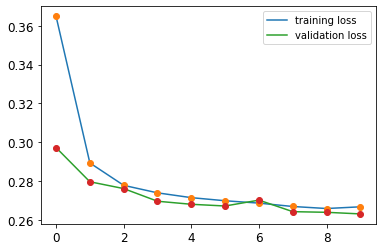

In [13]:
fig =  plt.figure()
plt.plot(training_loss,label = 'training loss')
plt.plot(training_loss,'o')
plt.plot(validation_loss, label = 'validation loss')
plt.plot(validation_loss, 'o')
plt.legend()
plt.xticks(size = 12)
plt.yticks(size = 12)

In [14]:
predictions = Predict(model, validation_loader, device) # Make predictions on input_valid. Notice we're not giving it any truth values!
print("\nRaw predictions: \n", predictions[:10])

# The output of our model is raw "logits" from the final output layer.
# This means it produces a pseudo score for each class (a score for 0 and a score for 1). 
# The function "expit" converts this logit to a number in [0,1].
# We then combine the logit scores such that our_score = (1_score) / (1_score + 0_score).
predictions = pd.DataFrame(predictions)
predictions.columns = ['not_bquark', 'bquark']
predictions['not_bquark'] = expit(predictions['not_bquark'])
predictions['bquark'] = expit(predictions['bquark'])
predictions = predictions['bquark']/(predictions['bquark'] + predictions['not_bquark'])

print("\nTransformed predictions: \n", predictions[:10])

PREDICTING!
Done Predicting!

Raw predictions: 
 [array([-0.47305417,  0.8063386 ], dtype=float32), array([ 2.4916613, -2.869637 ], dtype=float32), array([ 1.1633356, -1.2179376], dtype=float32), array([ 1.801605 , -2.0130286], dtype=float32), array([ 0.8582089 , -0.83499706], dtype=float32), array([ 0.78145885, -0.7434803 ], dtype=float32), array([ 0.94287014, -0.95293677], dtype=float32), array([ 2.3668773, -2.7150774], dtype=float32), array([-0.5966145 ,  0.95587444], dtype=float32), array([ 1.4451294, -1.5683266], dtype=float32)]

Transformed predictions: 
 0    0.642964
1    0.054926
2    0.230550
3    0.120717
4    0.301121
5    0.319611
6    0.278860
7    0.063593
8    0.670397
9    0.175669
dtype: float64


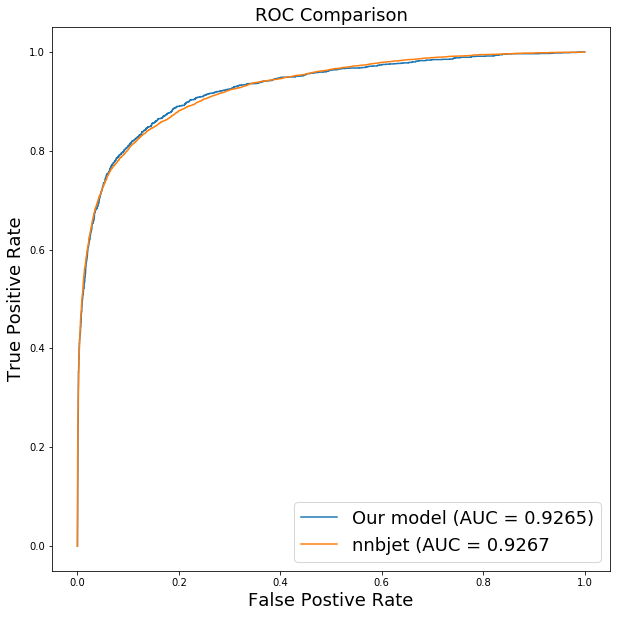

In [15]:
fpr, tpr, _ = roc_curve(truth_valid, predictions)      # False Positive Rate and True Positive Rate for our model
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth_data, benchmark_data) # False Positive Rate and True Positive Rate for ALEPH model

# We can now calculate the AUC scores of these ROC-curves:
auc_score = auc(fpr,tpr)                         # this is auc score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)   # this is the auc score for nnbjet

# Plot the results:
fig = plt.figure(figsize = [10,10])
plt.title('ROC Comparison', size = 18)
plt.xlabel('False Postive Rate', size = 18)
plt.ylabel('True Positive Rate', size = 18)
plt.plot(fpr,        tpr,        label = f'Our model (AUC = {auc_score:6.4f})')
plt.plot(fpr_nnbjet, tpr_nnbjet, label = f'nnbjet (AUC = {auc_score_nnbjet:6.4f}')
plt.legend(loc='lower right', fontsize=18)